In [4]:
!pip install scikit-fuzzy
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import skfuzzy as fuzz
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score

plt.style.use("seaborn-v0_8")
np.random.seed(42)

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 920.8/920.8 kB 18.9 MB/s eta 0:00:00


In [5]:
N = 600

RPM = np.random.uniform(1000, 7000, N)
Load = np.random.uniform(10, 90, N)

Temp = (
    30
    + 0.004*(RPM - 2000)
    + 0.09*Load
    + 0.5*np.sin((RPM/7000) * 2 * np.pi)
    + 0.02*Load*(RPM/7000)
    + np.random.normal(0, 1.2, N)
)

data = pd.DataFrame({"RPM": RPM, "Load": Load, "Temp": Temp})
data.head()

,RPM,Load,Temp
0,3247.240713,23.514805,39.314558
1,6704.285838,32.287227,52.131395
2,5391.963651,24.160839,44.952357
3,4591.950905,17.096203,43.972864
4,1936.111843,19.650870,30.377152


In [6]:
data.tail()

,RPM,Load,Temp
595,3843.769842,79.722944,44.122504
596,5005.346431,87.879118,50.252624
597,2033.919227,87.510228,40.310486
598,2153.734113,69.972147,40.072035
599,1245.211698,20.406899,31.191510


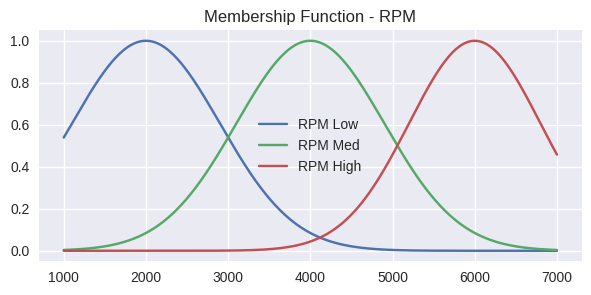

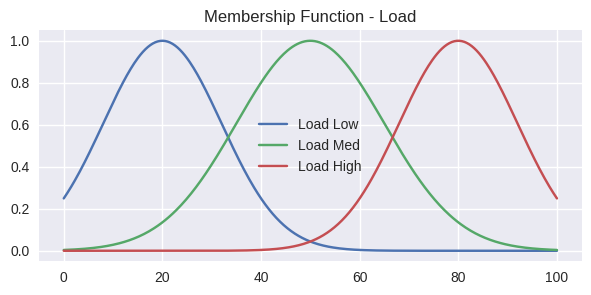

In [8]:
x_rpm = np.linspace(1000, 7000, 400)
rpm_low = fuzz.gaussmf(x_rpm, 2000, 900)
rpm_med = fuzz.gaussmf(x_rpm, 4000, 900)
rpm_high = fuzz.gaussmf(x_rpm, 6000, 800)

plt.figure(figsize=(7,3))
plt.plot(x_rpm, rpm_low, label="RPM Low")
plt.plot(x_rpm, rpm_med, label="RPM Med")
plt.plot(x_rpm, rpm_high, label="RPM High")
plt.legend()
plt.title("Membership Function - RPM")
plt.show()

# ... (bagian kode terpotong)

x_load = np.linspace(0, 100, 400)
load_low = fuzz.gaussmf(x_load, 20, 12)
load_med = fuzz.gaussmf(x_load, 50, 15)
load_high = fuzz.gaussmf(x_load, 80, 12)

plt.figure(figsize=(7,3))
plt.plot(x_load, load_low, label="Load Low")
plt.plot(x_load, load_med, label="Load Med")
plt.plot(x_load, load_high, label="Load High")
plt.legend()
plt.title("Membership Function - Load")
plt.show()

In [12]:
class ANFISManual:

    def __init__(self, n_inputs=2, n_mfs=3, lr=0.02):
        self.n_inputs = n_inputs
        self.n_mfs = n_mfs
        self.lr = lr

        self.centers = np.array([
            np.linspace(0.1, 0.9, n_mfs) for _ in range(n_inputs)
        ])
        self.sigmas = np.array([
            np.ones(n_mfs) * 0.15 for _ in range(n_inputs)
        ])

        self.n_rules = n_mfs ** n_inputs

        grids = np.meshgrid(*[np.arange(n_mfs) for _ in range(n_inputs)])
        self.rule_indices = np.vstack([g.flatten() for g in grids]).T

        self.w = np.zeros((self.n_rules, n_inputs + 1))

    def _gauss(self, x, c, s):
        return np.exp(-0.5 * (((x - c) / s)**2))

    def _firing(self, Xn):
        N = Xn.shape[0]
        F = np.zeros((N, self.n_rules))

        for r in range(self.n_rules):
            prod = np.ones(N)
            for i in range(self.n_inputs):
                idx = self.rule_indices[r,i]
                prod *= self._gauss(Xn[:,i], self.centers[i,idx], self.sigmas[i,idx])
            F[:,r] = prod

        return F


    def predict(self, Xn):
        F = self._firing(Xn)
        Wn = F / (F.sum(1, keepdims=True) + 1e-8)

        Xext = np.hstack([Xn, np.ones((Xn.shape[0],1))])
        y_rules = Xext @ self.W.T

        y = (Wn * y_rules).sum(axis=1, keepdims=True)
        return y, F, Wn


    def fit(self, Xn, y, epochs=30):
        history = []
        N = Xn.shape[0]

        for ep in range(epochs):

            F = self._firing(Xn)
            Wn = F / (F.sum(1, keepdims=True) + 1e-8)

            Xext = np.hstack([Xn, np.ones((N,1))])

            Phi = np.zeros((N, self.n_rules * (self.n_inputs + 1)))

            for r in range(self.n_rules):
                s = r * (self.n_inputs + 1)
                Phi[:, s:s+self.n_inputs+1] = Wn[:, r:r+1] * Xext

        Theta, *_ = np.linalg.lstsq(Phi, y, rcond=None)
        self.W = Theta.reshape(self.n_rules, self.n_inputs + 1)

        y_pred, _, _ = self.predict(Xn)
        loss = ((y - y_pred)**2).mean()
        history.append(loss)

        if (ep+1) % 5 == 0:
            print(f"Epoch {ep+1}/{epochs} - Loss: {loss:.4f}")

        return history


In [13]:
X = data[['RPM', 'Load']].values
Y = data['Temp'].values.reshape(-1, 1)

Xmin = X.min(0)
Xmax = X.max(0)
normalize = lambda X: (X - Xmin) / (Xmax - Xmin + 1e-8)

Xn = normalize(X)

Xtr, Xte, ytr, yte = train_test_split(Xn, Y, test_size=0.2, random_state=42)

anfis = ANFISManual()
history = anfis.fit(Xtr, ytr, epochs=30)

Epoch 30/30 - Loss: 1.3987


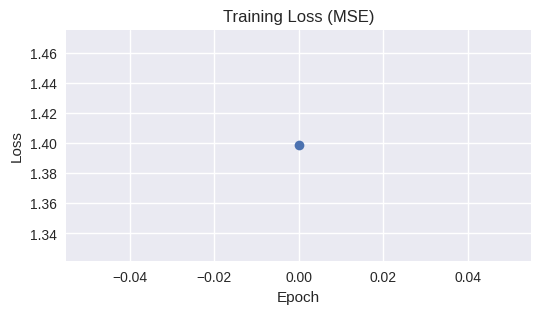

In [14]:
plt.figure(figsize=(6,3))
plt.plot(history, marker='o')
plt.title("Training Loss (MSE)")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.grid(True)
plt.show()

MSE: 1.5344028477813418
R² : 0.9747184494330132


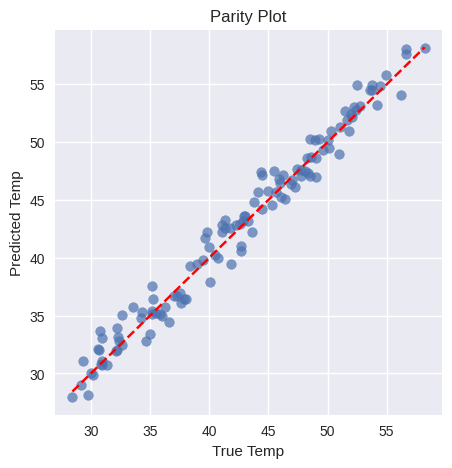

In [15]:
y_pred, _, _ = anfis.predict(Xte)

print("MSE:", mean_squared_error(yte, y_pred))
print("R² :", r2_score(yte, y_pred))

plt.figure(figsize=(5,5))
plt.scatter(yte, y_pred, alpha=0.7)
mn, mx = yte.min(), yte.max()
plt.plot([mn, mx], [mn, mx], 'r--')
plt.xlabel("True Temp")
plt.ylabel("Predicted Temp")
plt.title("Parity Plot")
plt.grid(True)
plt.show()

In [16]:
data['Temp_Pred'] = anfis.predict(normalize(data[['RPM', 'Load']].values))[0].flatten()
data.sample(10)

,RPM,Load,Temp,Temp_Pred
433,1606.736057,19.645351,31.476233,30.805565
150,6449.595316,19.351843,51.460469,49.788386
12,5994.655845,60.232031,50.502364,52.327957
492,2664.287098,58.618944,39.365899,38.371429
295,4133.459560,26.398744,41.448827,40.838735
228,6352.279331,69.000100,53.771060,54.914395
566,3353.464271,76.570734,44.954980,43.362549
192,6402.508343,50.471094,54.146842,53.199707
486,1272.678282,59.072911,32.304662,34.175700
186,5903.333201,56.671344,51.433652,51.521619
